# Signal synthesis

In this notebook we evaluate the data from the direct digital synthesis measurements in order to characterize the signal source quality.

In [3]:
duration = 26.84e-3
delays = np.linspace(0, duration, 300)

datadir = '../../dataset/signal/synthesis'
figuredir = '../../figure/signal/synthesis'

os.makedirs(figuredir, exist_ok=True)

We are interested in the signal amplitude in dependence of the frequency. Thus we will do a FFT on each segment to identify the dominant frequency and take the maximum voltage as amplitude. Then we compare the different configuration.

In [4]:
runs = {
    'horizontal-sinc-on': {},
    'horizontal-sinc-off': {},
    'vertical-sinc-on': {},
    'vertical-sinc-off': {},
}

for key, run in runs.items():
    for t in delays:
        run[t] = pd.read_hdf(os.path.join(datadir, f'{key}.h5'), str(t))

In [5]:
import transform

f_A = {}

for key, run in runs.items():
    d = f_A[key] = []

    for t, df in run.items():
        f, P = transform.fft(df.time, df.voltage)
        
        d.append((f[P.argmax()], df.voltage.max()))

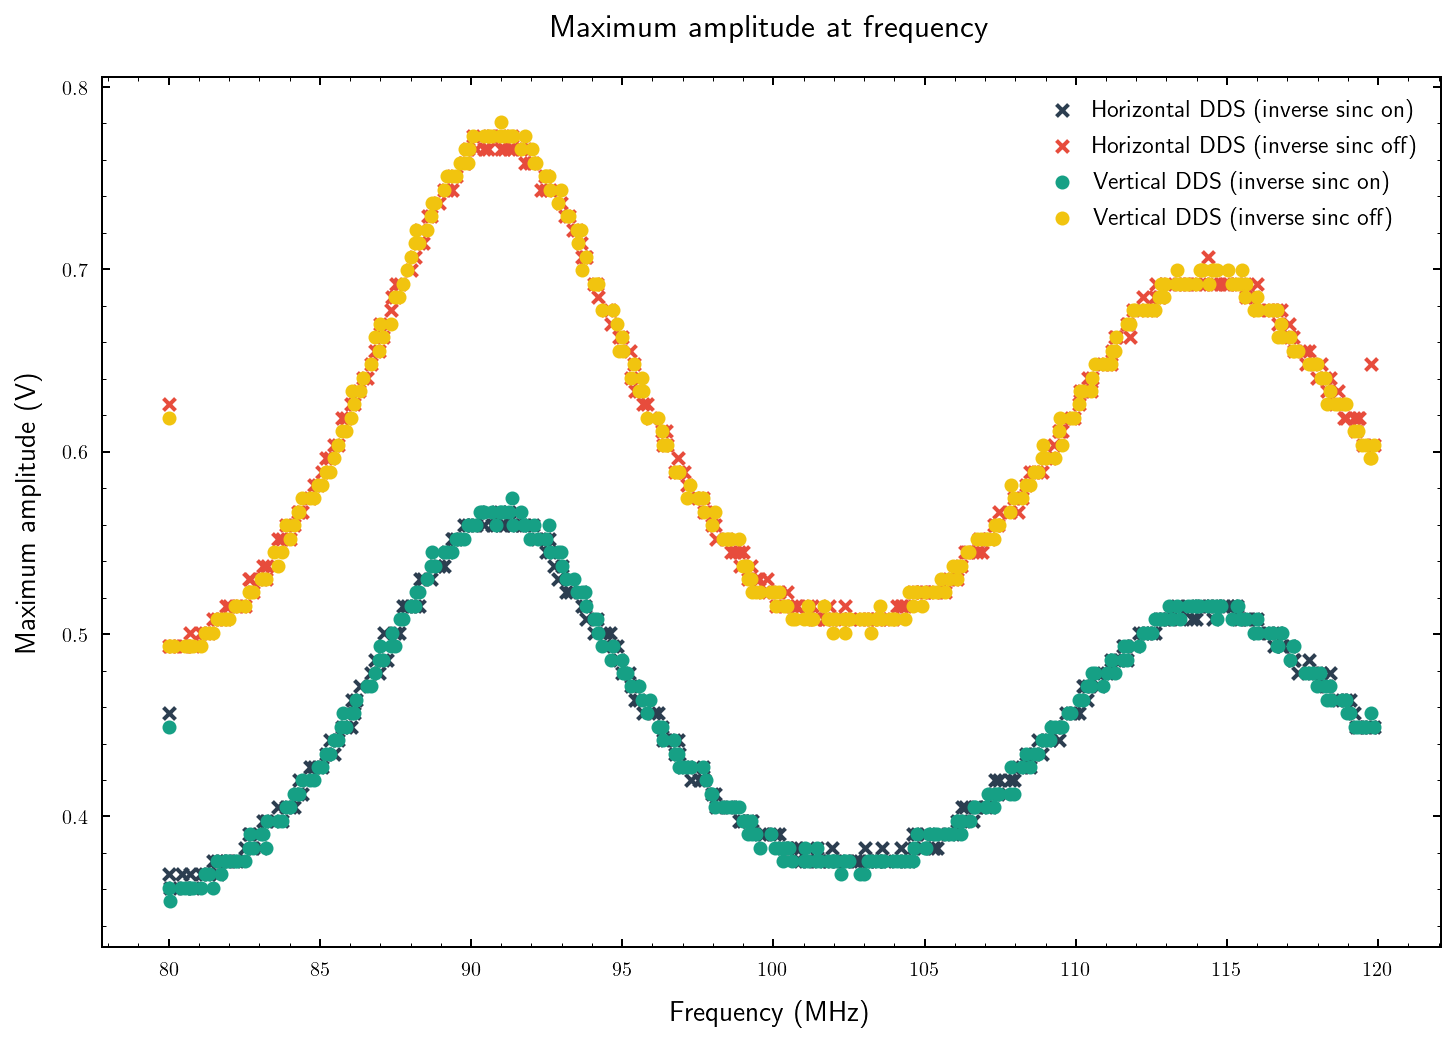

In [6]:
fig = plt.figure(figsize=(12, 8))

f, A = zip(*f_A['horizontal-sinc-on'])
plt.scatter(np.array(f) / 1e6, A, label='Horizontal DDS (inverse sinc on)', marker='x', color='#2c3e50')

f, A = zip(*f_A['horizontal-sinc-off'])
plt.scatter(np.array(f) / 1e6, A, label='Horizontal DDS (inverse sinc off)', marker='x', color='#e74c3c')

f, A = zip(*f_A['vertical-sinc-on'])
plt.scatter(np.array(f) / 1e6, A, label='Vertical DDS (inverse sinc on)', marker='o', color='#16a085')

f, A = zip(*f_A['vertical-sinc-off'])
plt.scatter(np.array(f) / 1e6, A, label='Vertical DDS (inverse sinc off)', marker='o', color='#f1c40f')

plt.title('Maximum amplitude at frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Maximum amplitude (V)')
plt.legend()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(os.path.join(figuredir, 'frequency-max-amplitude.pdf'))
plt.show()

In [33]:
from matplotlib import mlab

t0 = delays[0]
t1 = delays[99]
t2 = delays[199]
t3 = delays[299-3]

df = runs['horizontal-sinc-off']
dt = df[t0].time.diff()[1]

NFFT = 1024
Fs = 1/dt

Pxx1, freq1, bin1 = mlab.specgram(df[t0].voltage, NFFT=NFFT, Fs=Fs, noverlap=900)
Pxx2, freq2, bin2 = mlab.specgram(df[t1].voltage, NFFT=NFFT, Fs=Fs, noverlap=900)
Pxx3, freq3, bin3 = mlab.specgram(df[t2].voltage, NFFT=NFFT, Fs=Fs, noverlap=900)
Pxx4, freq4, bin4 = mlab.specgram(df[t3].voltage, NFFT=NFFT, Fs=Fs, noverlap=900)

minfreq = 60e6
maxfreq = 140e6

Pxx1 = Pxx1[(freq1 >= minfreq) & (freq1 <= maxfreq)]
Pxx2 = Pxx2[(freq2 >= minfreq) & (freq2 <= maxfreq)]
Pxx3 = Pxx3[(freq3 >= minfreq) & (freq3 <= maxfreq)]
Pxx4 = Pxx4[(freq4 >= minfreq) & (freq4 <= maxfreq)]

freq1 = freq1[(freq1 >= minfreq) & (freq1 <= maxfreq)]
freq2 = freq2[(freq2 >= minfreq) & (freq2 <= maxfreq)]
freq3 = freq3[(freq3 >= minfreq) & (freq3 <= maxfreq)]
freq4 = freq4[(freq4 >= minfreq) & (freq4 <= maxfreq)]

vmin = 10 * np.log10(np.min([Pxx1.min(), Pxx2.min(), Pxx3.min(), Pxx4.min()]))
vmax = 10 * np.log10(np.max([Pxx1.max(), Pxx2.max(), Pxx3.max(), Pxx4.max()]))

Z1 = 10 * np.log10(Pxx1)
Z1 = (Z1 - vmin) / (vmax - vmin)
Z1 = np.flipud(Z1)

Z2 = 10 * np.log10(Pxx2)
Z2 = (Z2 - vmin) / (vmax - vmin)
Z2 = np.flipud(Z2)

Z3 = 10 * np.log10(Pxx3)
Z3 = (Z3 - vmin) / (vmax - vmin)
Z3 = np.flipud(Z3)

Z4 = 10 * np.log10(Pxx4)
Z4 = (Z4 - vmin) / (vmax - vmin)
Z4 = np.flipud(Z4)

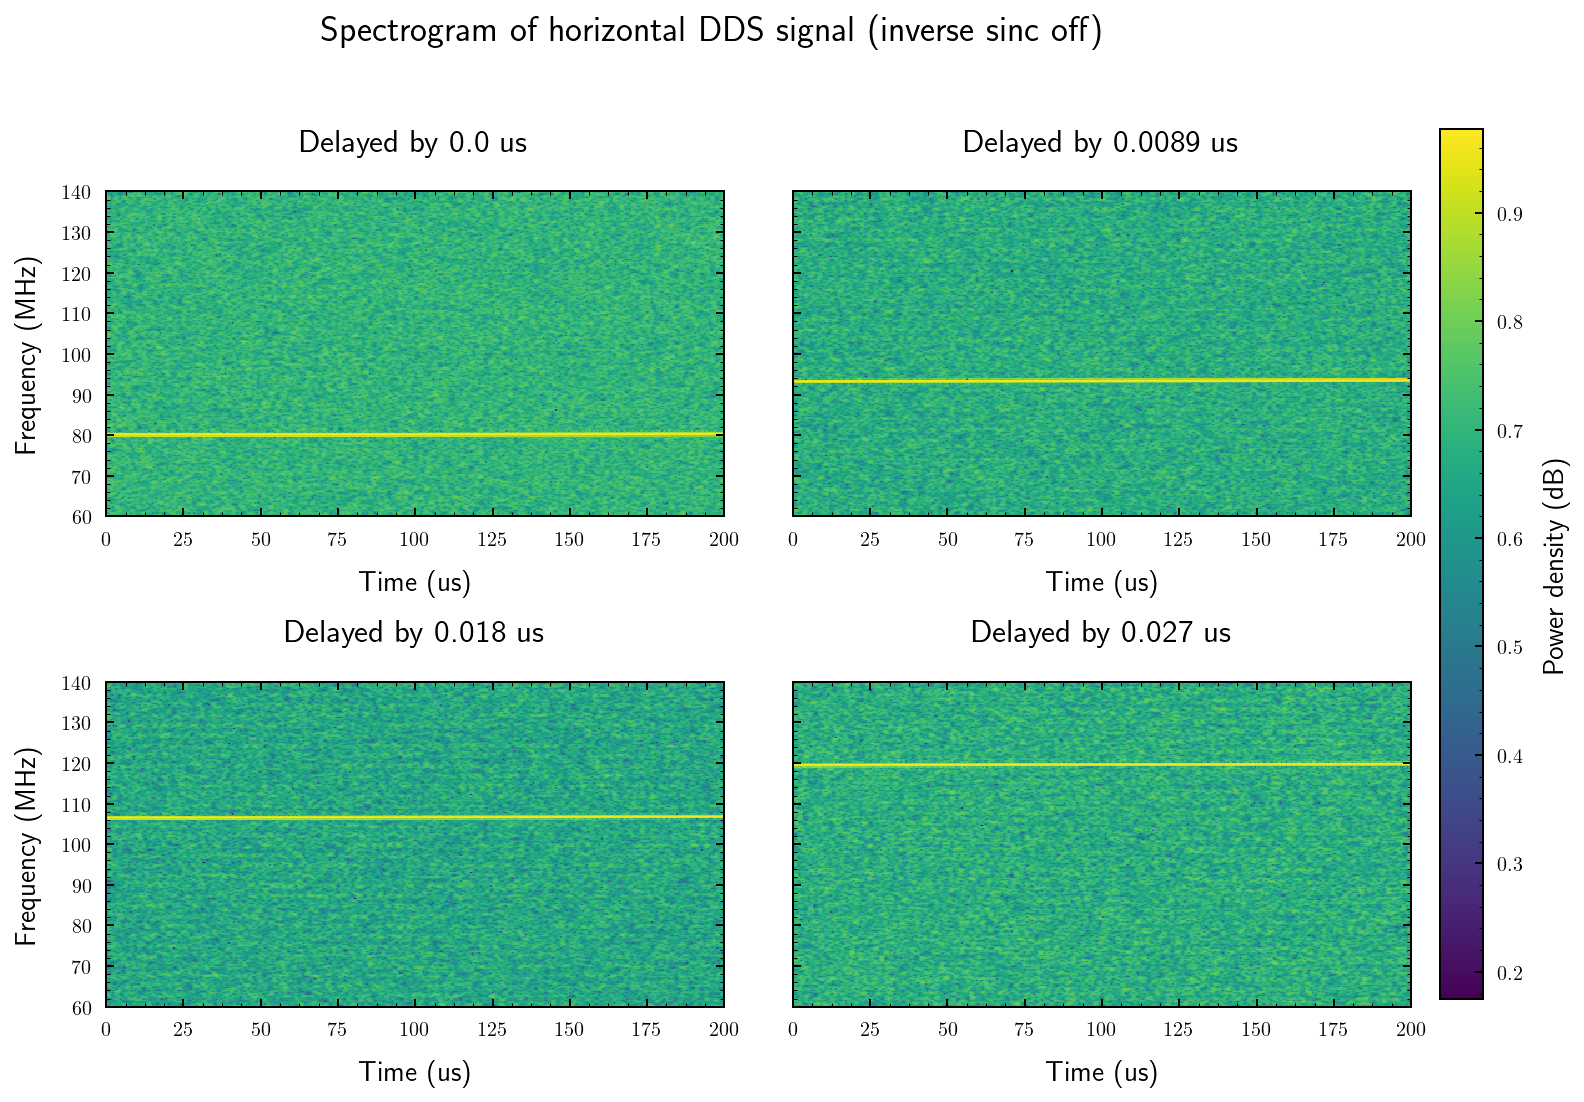

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharey=True)
fig.suptitle('Spectrogram of horizontal DDS signal (inverse sinc off)')

axes = axes.flatten()
axes[0].set_title(f'Delayed by {t0:.2} us')
axes[0].set_ylabel('Frequency (MHz)')
axes[0].imshow(Z1, extent=[0, 200, 60, 140])
axes[1].set_title(f'Delayed by {t1:.2} us')
axes[1].imshow(Z2, extent=[0, 200, 60, 140])
axes[2].set_title(f'Delayed by {t2:.2} us')
axes[2].imshow(Z3, extent=[0, 200, 60, 140])
axes[2].set_ylabel('Frequency (MHz)')
axes[3].set_title(f'Delayed by {t3:.2} us')
im = axes[3].imshow(Z4, extent=[0, 200, 60, 140])

for axis in axes:
    axis.set_xlabel('Time (us)')
    axis.axis('auto')

fig.subplots_adjust(right=1.16)
fig.colorbar(im, ax=list(axes), label='Power density (dB)')

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
fig.savefig(os.path.join(figuredir, 'spectrogram.pdf'))
plt.show()

## Conclusion

We find that the amplitude of the DDS has a frequency dependence. The datasheet suggests that this is an intrinsic property of direct digital synthesis and advertises an inverse sinc filter to circumvent the frequency dependence.

We find that the inverse sinc filter does not really eliminate the frequency dependence of the amplitude but decreases the overall power output, henceforth we decide to not use the inverse sinc filter in any further experiments.